## Overdispersion estimation from the cluster size distributions outside China

## Background
A novel coronavirus (2019-nCoV) outbreak has been continuing in China, while a few imported cases are observed in the neighbouring countries. Although the spread across China exihibited substantial amount of human-to-human transmisison, there have not been as many secondary cases observed in the countries with travel cases as we might expect from the estimate of $R_0$ around 2-3. This suggests that not all symptomatic cases lead to a secondary transmission, which was also the case in the past SARS/MERS outbreaks. Furthermore, even if any subclinical cases had been imported into these countries undetected, at least such cases did not contributed to secondary transmissions from which a detectable case originates.


## Method
Cluster size distribution for geometric distribution generated from $s$ initial cases is given as
$$
P(X=x;s)=\frac{ks}{kx+x-s}\binom{kx+x-s}{x-s}\frac{\left(\frac{R_0} k\right)^{x-s}}{\left(1+\frac{R_0} k\right)^{kx+x-s}}.
$$

We assumed that the growth of a cluster in a country has been ceased if 7 days are passed since the latest reported cases (ceased countries: $A$). We applied the above likelihood to those ceased countries. The final cluster sizes are unknown for the remaining countries (ongoing countries: $B$); therefore, we only used the information that the final size would be larger than the current cluster size, i.e.
$$
P(X\geq x;s)=1-\sum_{m=0}^{x}P(X=m;s)+P(X=x;s)
$$

The total likelihood is
$$
L(R_0,k)=\prod_{i\in A}P(X=x_i;s_i)\prod_{i\in B}P(X\geq x_i;s_i)
$$

In [193]:
currdate=as.Date("2020-2-18")
# buffer period: we assume the growth of a cluster is ceased when this period has been passed since the latest case report
buffer=7

In [194]:
# Data
# Imported and local cases outside China
# Source (accessed 18/2/2020): https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200218-sitrep-29-covid-19.pdf
WHO_data=read.csv("../data/bycountries.csv")
rownames(WHO_data)=WHO_data[,1]

# modification of numbers
modifydata<-function(country,from,to,howmany){
    WHO_data[country,from]=WHO_data[country,from]-howmany
    WHO_data[country,to]=WHO_data[country,to]+howmany
    return(WHO_data)
}
#‡The exposure for 3 cases occurred outside of Republic of Korea.
WHO_data=modifydata("South Korea","Local","Imported",3)
#§The exposure for 1 case occurred outside of Malaysia. One patient also had travel history to China, but exposure likely occurred after return to Malaysia.
WHO_data=modifydata("Malaysia","Local","Imported",1)
#**The exposure for 6 cases occurred outside of the United Kingdom.
WHO_data=modifydata("UK","Local","Imported",6)
#††The exposure for 2 cases occurred outside of Spain
WHO_data=modifydata("Spain","Local","Imported",2)
# Isolated local case in Egypt 
WHO_data=modifydata("Egypt","Local","Imported",1)

# Remove Cruise ship data
#WHO_data=WHO_data[-nrow(WHO_data),]

# Daily confirmed cases (by date of confirmation)
# Source (accessed 18/2/2020): https://docs.google.com/spreadsheets/d/1Z7VQ5xlf3BaTx_LBBblsW4hLoGYWnZyog3jqsS9Dbgc
daily_data=read.csv("../data/dailycases_international.csv")
countrynames=daily_data[-(1:2),2]
names(countrynames)=as.character(countrynames)
counts=suppressWarnings(apply(t(daily_data[-(1:2),-(1:2)]),1:2,as.numeric))
dates=as.Date("2020-1-13")+1:nrow(counts)-1
dailydata=cbind(dates,as.data.frame(counts))
rownames(dailydata)=dailydata[,1]
colnames(dailydata)=c("date",as.character(countrynames))

# get dates of last reported case for each country
latestdates=data.frame(countrynames,latestdate=as.Date(apply(dailydata[,-1],2,function(x){
    lastreported=tail(which(!(x %in% NA)),1)
    as.character(dailydata[lastreported,1])
})))

# get the number of cases within the buffer period
bufferdays=seq(currdate-buffer,currdate,by="days")
ongoingbranches=colSums(dailydata[as.character(bufferdays),-1],na.rm=T)

# reorder latestdates and ongoingbranches according to WHO data
latestdates_WHO=latestdates[rownames(WHO_data),2]
ongoingbranches_WHO=ongoingbranches[rownames(WHO_data)]
WHO_data=cbind(WHO_data,latestdate=latestdates_WHO,ongoingbranches=ongoingbranches_WHO)
head(WHO_data)

,ï..,Total,new.Total,Imported,new.Imported,Local,new.Local,Unknown,new.Unknown,Death,new.Death,latestdate,ongoingbranches
,<fct>,<int>,<int>,<dbl>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<date>,<dbl>
Singapore,Singapore,77,2,23,1,53,1,1,0,0,0,2020-02-18,36
Japan,Japan,65,6,26,0,39,6,0,0,1,0,2020-02-18,48
South Korea,South Korea,31,1,16,0,12,1,3,0,0,0,2020-02-19,4
Malaysia,Malaysia,22,0,18,0,3,0,1,0,0,0,2020-02-15,4
Vietnam,Vietnam,16,0,8,0,8,0,0,0,0,0,2020-02-13,2
Australia,Australia,15,0,12,0,3,0,0,0,0,0,2020-02-06,0


In [195]:
# label countries with/without cases in the last (buffer) days
isextinct=WHO_data$latestdate<currdate-buffer
icases=WHO_data$Imported
lcases=WHO_data$Local
ocases=WHO_data$ongoingbranches

In [196]:
# cluster size inference
# for extinct clusters
llextinct<-function(icases,lcases,R0,k){
    if(length(icases)==0)return(0)
    tcases=lcases+icases
    lls=log(k*icases)-log((k+1)*tcases-icases)+lchoose((k+1)*tcases-icases,tcases-icases)+(tcases-icases)*log(R0/k)-((k+1)*tcases-icases)*log(1+R0/k)
    sum(lls,na.rm=T)
}

# only use the number as the lower bound of cluster size for ongoing countries
lltruncate<-function(icases,lcases,R0,k){
    if(length(icases)==0) return(0)
    ll=0
    for(i in 1:length(icases)){
        prob=1
        if(icases[i]==0||lcases[i]==0)next
        for(x in 0:(lcases[i]-1)){
            prob=prob-exp(llextinct(icases[i],x,R0,k))
        }
        if(!is.nan(prob))ll=ll+log(max(0,prob))
    }
    return(ll)
}

# use the info of cases before the buffer period
llongoing<-function(icases,lcases,ocases,R0,k){
    if(length(icases)==0)return(0)
    tcases=lcases+icases
    lls=log(k*icases)-log((k+1)*tcases-icases)+lchoose((k+1)*tcases-icases,tcases-icases)+(tcases-icases)*log(R0/k)-((k+1)*tcases-icases)*log(1+R0/k)
    #adjust for ongoing branches
    lls=lls-dnbinom(0,k,mu=R0,log=T)*ocases-lchoose(tcases,ocases)
    sum(lls,na.rm=T)
}

lltotal<-function(nbparm,icases,lcases,ocases,isextinct){
    nbparm=exp(nbparm)
    R0=nbparm[1];k=nbparm[2]
    llextinct(icases[isextinct],lcases[isextinct],R0,k)+llongoing(icases[!isextinct],lcases[!isextinct],ocases[!isextinct],R0,k)
}
lltotal_R0<-function(k,icases,lcases,ocases,isextinct,R0){
    llextinct(icases[isextinct],lcases[isextinct],R0,k)+llongoing(icases[!isextinct],lcases[!isextinct],ocases[!isextinct],R0,k)
}
lltotal2<-function(nbparm,icases,lcases,isextinct){
    nbparm=exp(nbparm)
    R0=nbparm[1];k=nbparm[2]
    llextinct(icases[isextinct],lcases[isextinct],R0,k)+lltruncate(icases[!isextinct],lcases[!isextinct],R0,k)
}
lltotal2_R0<-function(k,icases,lcases,isextinct,R0){
    llextinct(icases[isextinct],lcases[isextinct],R0,k)+lltruncate(icases[!isextinct],lcases[!isextinct],R0,k)
}

In [197]:
# Test block
R0=runif(100,0,5);k=runif(100,0,5)
# equals negbinom when x==s
all.equal(dnbinom(0,k,mu=R0,log=T),sapply(1:length(R0),function(x)llextinct(1,0,R0[x],k[x])))
# sum up to (almost) 1 when R0<<1
R0=runif(30)/2                                         
lls=sapply(1:length(R0),function(x)lltruncate(sample(1:5,1),3e4,R0[x],k[x]))
all.equal(exp(lls),numeric(length(R0)))

[1] TRUE

[1] TRUE

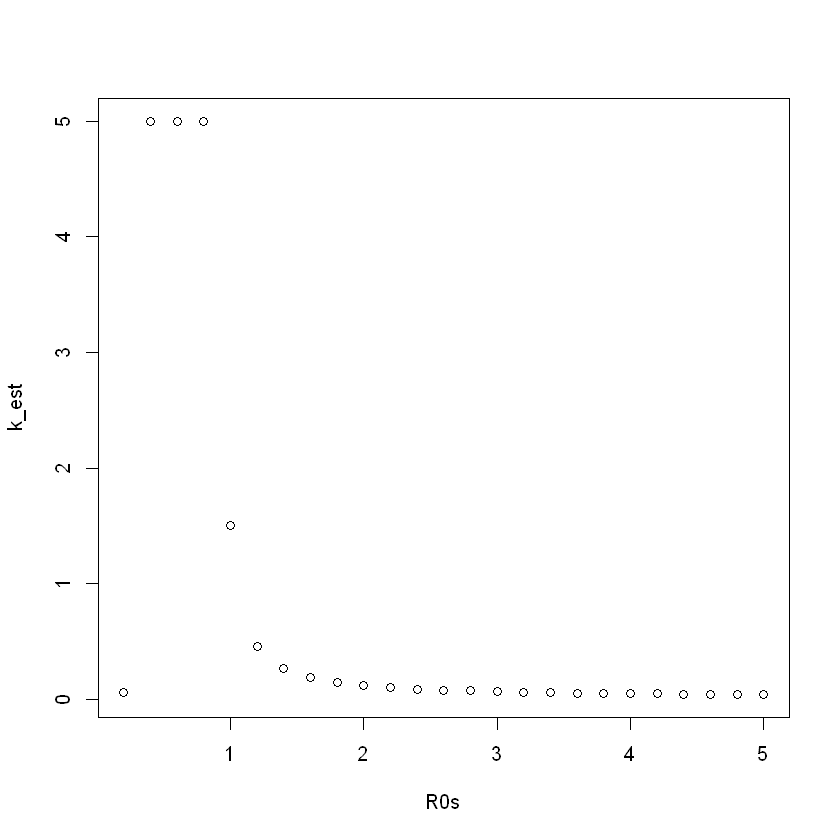

In [198]:
# Optimise
#opt=optim(fn=lltotal,par=c(1,1),method="L-BFGS",lower=c(1e-2,1e-2),upper=c(10,10),icases=icases,lcases=lcases,isextinct=isextinct,control=list(fnscale=-1))
estimatek<-function(R0){
    opt=optim(fn=lltotal_R0,par=1,method="Brent",lower=0,upper=5,icases=icases,lcases=lcases,ocases=ocases,isextinct=isextinct,R0=R0,control=list(fnscale=-1,trace=1))
    opt$par
}

R0s=1:25/5
k_est=sapply(R0s,estimatek)
plot(x=R0s,y=k_est)


In [ ]:
# MCMC
library(LaplacesDemon)
Data=Data=list(N=13,mon.names=c("nlogl","R0"),parm.names="overdispersion k",R0=1,icases=icases,lcases=lcases,ocases=ocases,isextinct=isextinct)
Model=function(parm,Data){
    k=interval(parm,0)
    ll=lltotal_R0(k,Data$icases,Data$lcases,Data$ocases,Data$isextinct,Data$R0)
    return(list(LP=ll,Dev=-2*ll,Monitor=c(ll,Data$R0),yhat=NULL,parm=k))
}
#fit<-LaplacesDemon(Model=Model,Data=Data,Initial.Values=1,Covar=NULL,Iterations=10000,Status=1000,Thinning=10,Algorithm='HARM',Specs=NULL)

R0s=1:25/5
niter=10000
k_est=sapply(R0s,function(R0){
    Data$R0=R0
    fit=LaplacesDemon(Model=Model,Data=Data,Initial.Values=1,Covar=NULL,Iterations=niter,Status=niter,Thinning=10,Algorithm='HARM',Specs=list(alpha.star=0.23,B=NULL))
    fit$Posterior1[(niter%/%20):(niter%/%10)]
})

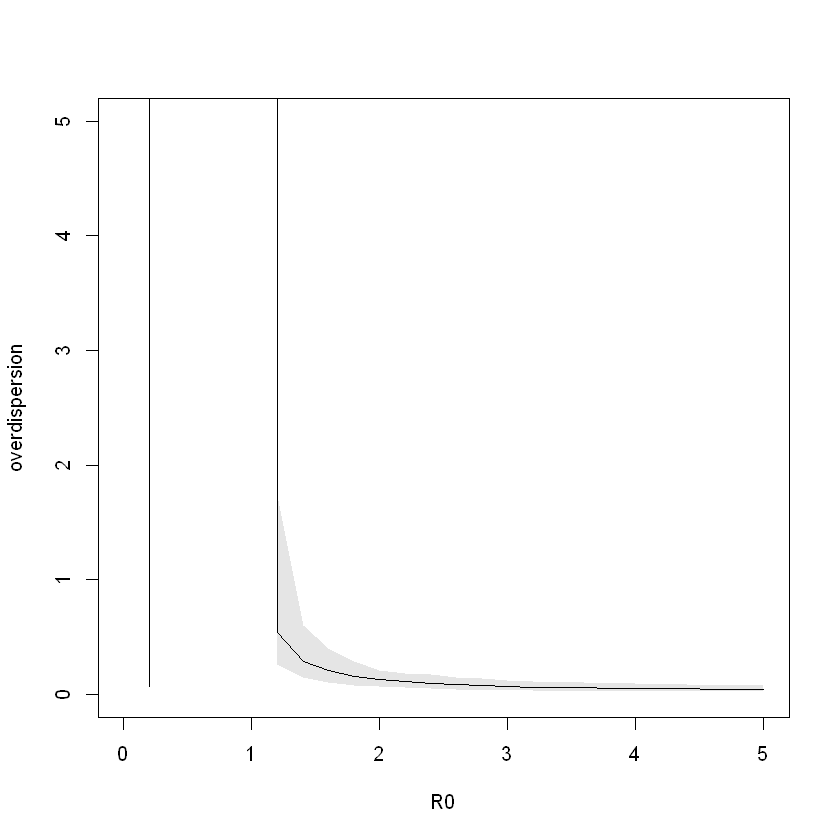

In [250]:
# Plot
med=apply(k_est,2,median)
cri=apply(k_est,2,function(x){quantile(x,c(0.025,0.975))})
plot(x=R0s,y=med,xlim=c(0,5),ylim=c(0,5),type="l",xlab="R0",ylab="overdispersion")
polygon(x=c(R0s,rev(R0s)),y=c(cri[1,],rev(cri[2,])),lty=0,col=rgb(0,0,0,0.1))

In [251]:
# Joint estimation
Data=Data=list(N=13,mon.names=c("nlogl","R0"),parm.names=c("R0","k"),icases=icases,lcases=lcases,ocases=ocases,isextinct=isextinct)
Model_joint=function(parm,Data){
    parm=interval(parm,0)
    ll=lltotal(parm,Data$icases,Data$lcases,Data$ocases,Data$isextinct)
    return(list(LP=ll,Dev=-2*ll,Monitor=c(ll,0),yhat=NULL,parm=parm))
}
#fit<-LaplacesDemon(Model=Model,Data=Data,Initial.Values=1,Covar=NULL,Iterations=10000,Status=1000,Thinning=10,Algorithm='HARM',Specs=NULL)
niter=10000
fit=LaplacesDemon(Model=Model_joint,Data=Data,Initial.Values=c(1,1),Covar=NULL,Iterations=niter,Status=niter,Thinning=10,Algorithm='HARM',Specs=list(alpha.star=0.23,B=NULL))



Laplace's Demon was called on Sat Feb 22 08:48:37 2020

Performing initial checks...
Algorithm: Hit-And-Run Metropolis 

Laplace's Demon is beginning to update...
Iteration: 100000,   Proposal: Multivariate,   LP: -156.2

Assessing Stationarity
Assessing Thinning and ESS
Creating Summaries
Creating Output

Laplace's Demon has finished.


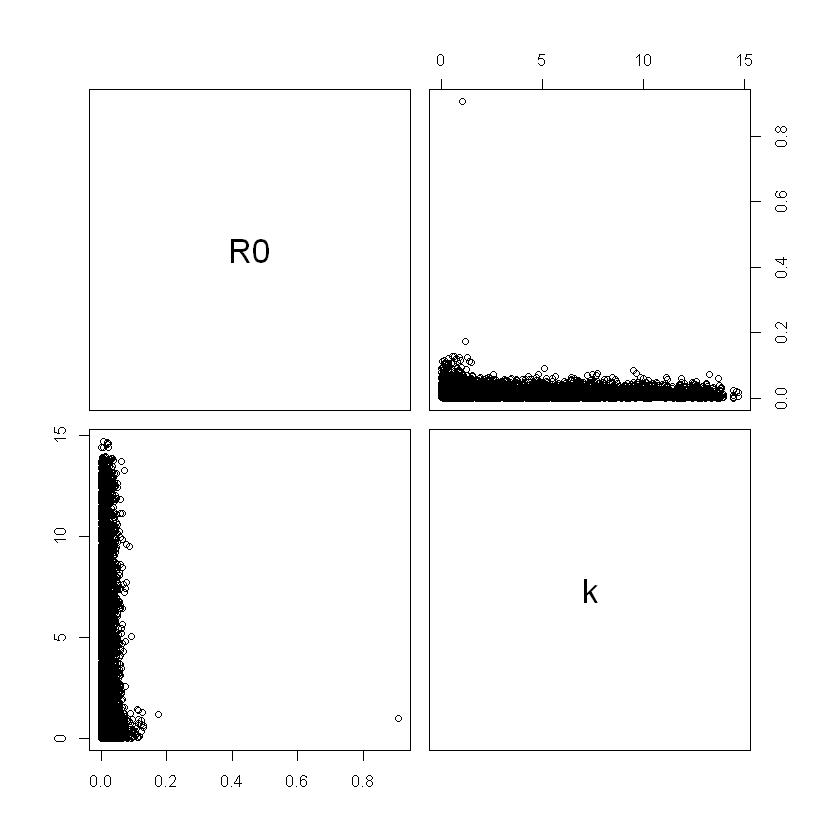

In [255]:
pairs(fit$Posterior1[,1:2])